### COMP5349 Week 9 Spark Machine Learning Example ###

This is a sample notebook showing how to use Sparking Machine Learning library. In particular, it shows how to prepare data as input to a machine learning model and how to convert the output back to local data structure for further processing, such as visualization.

The program uses the classic MINST dataset of handwritten digit[http://yann.lecun.com/exdb/mnist/]. To facilitate processing, we have converted the original data set into corresponding csv files. 

The notebook demonstrates the usage of two algrothms: PCA and KMeans. It uses the test data set only, which is much smaller and can run locally.  

### Lab Exercises ###
 * Try to run the orginal notebook and observe the output.
 * Organize the PCA-KMEANS sequence into a pipeline, then run the whole pipeline to produce a model and use that model to computer cluster membership
 * Use PCA to project the original features to 3 or more dimensions and use the new PCA results to run kmeans algorithm
 * Run k-means on the original pixel value to compare the results and observe difference in execution time
 * Convert the notebook to python script and run it on the cluster using the training data set, observe the running statistics and execution time under different settings (e.g. executor numbers).


In [17]:
# Import all necessary libraries and setup the environment for matplotlib
%matplotlib inline
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.ml.feature import PCA
from pyspark.ml.clustering import KMeans
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
import numpy as np
import matplotlib.pyplot as plt

##### Load the data in csv file #####

The following cell load the image data from a headless csv file (line 10). Each row of the csv file contains the raw pixel value of an image. The value is an integer beween 0-255. 0 means background (white), 255 means foreground (black). The image is of 28x28 pixels. It is flattened to an vactor of 748 values. Hence each row contains 748 columns. Spark is instructed to infer the schema from files. 

The data file is loaded initially as a data frame consiting of rows, each row having 748 columns with default names like _c0, _c1,.... 


In [18]:
spark = SparkSession \
    .builder \
    .appName("Python Spark Machine Learning Example") \
    .getOrCreate()

test_datafile = "hdfs://soit-hdp-pro-1.ucc.usyd.edu.au/share/MNIST/Test-28x28.csv"
test_labelfile= "Test-label.csv"
num_test_samples = 10000

test_df = spark.read.csv(test_datafile,header=False,inferSchema="true")

##### Converting  to Vector row#####
Most machine learning algorithms expect individual input data to be a vector representing features of data point. Instead of having 748 columns each of integer type per row, we need a single column of vector type per row. The column is usually called "features". Spark provides a mechanism called ``VectorAssembler`` to combine a number of columns into a single vector column [https://people.apache.org/~pwendell/spark-nightly/spark-master-docs/latest/ml-features.html#vectorassembler].    

The following cell combines all columns in the dataframe to a single column called features of type Vector. The value of the first two rows are displayed. You may notice that Spark has chosen to use SparseVector format to represent the image pixel values. All images in MNIST have large portion of white background, meaning a pixel value of 0. For instance, the first row have 0s in the first 202 features, feature 202, 203,204,ect have non-zero values.   

In [19]:
assembler = VectorAssembler(inputCols=test_df.columns,
    outputCol="features")
test_vectors = assembler.transform(test_df).select("features")
test_vectors.show(2)

+--------------------+
|            features|
+--------------------+
|(784,[202,203,204...|
|(784,[94,95,96,97...|
+--------------------+
only showing top 2 rows



##### Display the actual digit #####
The following cells take the first row of the data frame and return its value to the driver program. It is converted into a numpy array and reshaped backed to an 28x28 matrix and displayed as gray scale image.

(-0.5, 27.5, 27.5, -0.5)

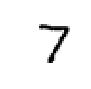

In [20]:
#display the actual image of the first digit
first_digit = np.array(test_vectors.head(1))
plt.figure(figsize=(1,1))
plt.imshow(first_digit[0].reshape(28,28), cmap="gray_r")
plt.axis('off')

##### Project data point in a two dimensional space #####

The following cell uses PCA transformation to project the 748 feature vectors into 2-dimensional principal components. Line 1 creates a PCA instance, line 2 trains moddel with given data set: ``test_vectors``. Line 3 uses the trained model to perform actual transformation on the data set: ``test_vectors``. We are only interested in the transformed vector, so  we select the column corresponds to the output ``pca`` 

In [21]:
pca = PCA(k=2, inputCol="features", outputCol="pca")
model = pca.fit(test_vectors)
pca_result = model.transform(test_vectors).select('pca')

##### Inspect the PCA projected vectors#####
Next we collect the PCA results as a local variable and display the top five vectors

In [22]:
local_pca=np.array(pca_result.collect())
local_pca[:5]

array([[[  377.95005242,  -672.74411225]],

       [[  847.27698375,   996.98775786]],

       [[ -145.89428998,   472.89215895]],

       [[ 2044.87755474,   -93.17504338]],

       [[  922.09809785,  -730.72434723]]])

In [23]:
#reshape it to 2d array
local_pca=local_pca.reshape((num_test_samples,2))

#### Read label file locally using numpy #####
The next cell read the label file into a list using ``numpy``'s ``genfromtext`` function.

In [24]:
labels = np.genfromtxt(test_labelfile,dtype=None)
labels[:5]

array([7, 2, 1, 0, 4])

#### Visualize the 2-d projected vector ####
Visualization is an easy way to check if the performed PCA projection is a good representation of the original data. We plot the data in a scatterplot, data points are painted in different colors based on their label. The data set consists of 10 classes, we expect to see some natural clusterings if the 2-D projection preserves important original features. The visualization shows that for label 1 and 0, there are some natural clusterings, but data points of all other lables are scattered. It suggestss that the first two principle components may not be a good representation, we may need to take more components if we want to use PCA as dimension reduction tool.

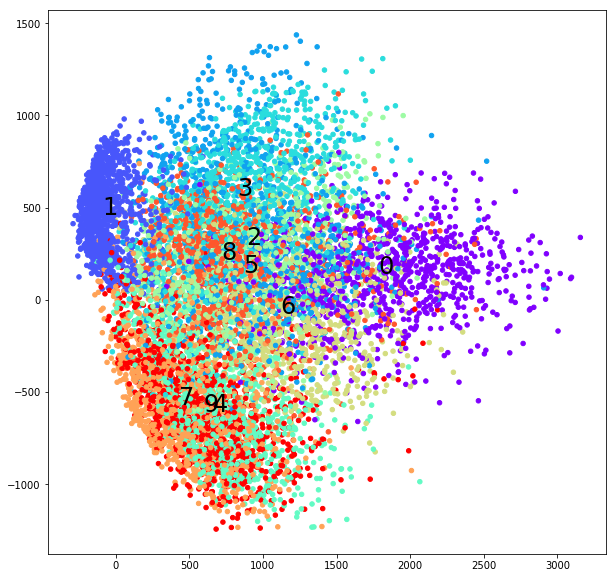

In [25]:
plt.figure(figsize=(10,10))
plt.scatter(local_pca[:, 0], local_pca[:, 1], s=20, c=labels,cmap='rainbow')
txts = []
for i in range(10):
# Position of each label.
    xtext, ytext = np.median(local_pca[labels == i, :], axis=0)
    txt = plt.text(xtext, ytext, str(i), fontsize=24)
    txts.append(txt)


#### KMeans Example #####
    
The next cell demonstrate the usage of another algorithm K-Means[https://people.apache.org/~pwendell/spark-nightly/spark-master-docs/latest/ml-clustering.html].  To facilitate visualization, we run k-means on the projected 2-d data set. In line 1,the KMeans instance is created and we specify to use features stored in the "pca" column. We apply the same sequence of ``fit`` followed by ``transform``. After running ``transform``, a new colum called ``prediction`` will be added to each data point. The column saves the cluser membership of that data point, indicated as an integer cluster id.   

In [26]:
kmeans = KMeans(featuresCol='pca',k=10)
model=kmeans.fit(pca_result)
predictions = model.transform(pca_result)
centers = model.clusterCenters()

#### Visuazliation the K-means Results #####
The next few cells collect the results locally and convert them in proper format for visualization

In [27]:
local_kmeans_data= predictions.select('pca','prediction').collect()
local_kmeans_data[:10]

[Row(pca=DenseVector([377.9501, -672.7441]), prediction=6),
 Row(pca=DenseVector([847.277, 996.9878]), prediction=9),
 Row(pca=DenseVector([-145.8943, 472.8922]), prediction=3),
 Row(pca=DenseVector([2044.8776, -93.175]), prediction=1),
 Row(pca=DenseVector([922.0981, -730.7243]), prediction=5),
 Row(pca=DenseVector([-223.5584, 542.846]), prediction=3),
 Row(pca=DenseVector([437.1598, -529.0525]), prediction=6),
 Row(pca=DenseVector([433.7394, -301.182]), prediction=4),
 Row(pca=DenseVector([1044.6909, -181.6728]), prediction=0),
 Row(pca=DenseVector([722.999, -788.8331]), prediction=5)]

In [28]:
kmeans_points = [v.pca.values.tolist() for v in local_kmeans_data]
kmeans_points[:10]

[[377.95005242441636, -672.7441122524905],
 [847.2769837472326, 996.9877578568412],
 [-145.894289979091, 472.8921589522258],
 [2044.8775547373803, -93.17504337948401],
 [922.0980978452897, -730.7243472342717],
 [-223.558362450273, 542.8460242186042],
 [437.15980028754717, -529.0525208697798],
 [433.7393632856144, -301.1819935188354],
 [1044.6908798506602, -181.6728225525823],
 [722.9990116852714, -788.8331099788712]]

In [29]:
kmeans_labels=[v.prediction for v in local_kmeans_data]
kmeans_labels[:10]

[6, 9, 3, 1, 5, 3, 6, 4, 0, 5]

In [30]:
center_points = np.array([v.tolist() for v in centers])
center_points

array([[  942.06305128,  -114.70694692],
       [ 2165.05648135,   168.27978994],
       [ 1494.19003795,   -44.13622738],
       [  -30.26417437,   461.12914751],
       [  274.2763778 ,  -149.76861886],
       [  956.13253268,  -806.67934156],
       [  478.05307748,  -620.60054336],
       [ 1316.72575429,   544.01917774],
       [  660.66613775,   294.22646496],
       [  763.96431713,   797.38969584]])

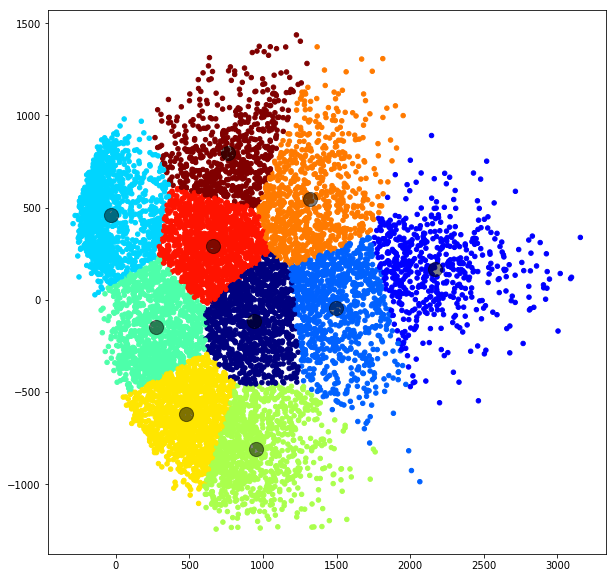

In [31]:
kmeans_points= np.array(kmeans_points)
plt.figure(figsize=(10,10))
plt.scatter(kmeans_points[:, 0], kmeans_points[:, 1], s=20, c=kmeans_labels,cmap='jet')
plt.scatter(center_points[:, 0], center_points[:, 1], s=200,c='black', alpha=0.5);

In [32]:
spark.stop()